In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict, defaultdict
import random

from qiskit.quantum_info import Statevector, random_statevector
from qiskit.visualization import array_to_latex, plot_histogram
from qiskit.visualization.bloch import Bloch

In [167]:
def decimalToBinary(n, dim):
    return "0"*(dim - len(bin(n).replace("0b", ""))) + bin(n).replace("0b", "")

def mitigate_matrix(num_qubits):
    error_01 = 0.05
    error_10 = 0.01
    matrix = np.zeros((2**num_qubits, 2**num_qubits))
    for i in range(2**num_qubits):
        for j in range(2**num_qubits):
            if i != j:
                matrix[i][j] = 0.05**(decimalToBinary(i, num_qubits).count('1')) * 0.01**(decimalToBinary(i, num_qubits).count('0'))
            else:
                matrix[i][i] = 1 - 0.05**(decimalToBinary(i, num_qubits).count('1')) * 0.01**(decimalToBinary(i, num_qubits).count('0'))
    return np.linalg.inv(matrix)

In [183]:
def mitigate(num_qubits):
    E = np.array([[0.99, 0.01], 
                    [0.05, 0.95]])
    op = E
    for i in range(num_qubits-1):
        op = np.kron(op, E)
    
    return np.linalg.inv(op)

def dict_to_state(d):
    first_label = list(d.keys())[0]
    num_qubits = len(first_label)
    num_shots = sum(d.values())
    state = np.sqrt(d[first_label]/num_shots)*Statevector.from_label(first_label)
    
    for label in list(d.keys())[1:]:
        state += np.sqrt((d[label]/num_shots))*Statevector.from_label(label)
    return state

def scramble(all_measurements):
    error_rate_0_to_1 = 0.05
    error_rate_1_to_0 = 0.01
    scrambled_results = defaultdict(int)

    # Process each bitstring in the original OrderedDict
    for bitstring, count in all_measurements.items():
        state_distribution = defaultdict(int)
        
        # Simulate errors for each measurement count
        for _ in range(count):
            new_bitstring = []
            for bit in bitstring:
                if bit == '0':
                    new_bitstring.append('1' if random.random() < error_rate_0_to_1 else '0')
                elif bit == '1':
                    new_bitstring.append('0' if random.random() < error_rate_1_to_0 else '1')
            new_bitstring = ''.join(new_bitstring)
            state_distribution[new_bitstring] += 1

        # Accumulate the simulated results into the scrambled_results dictionary
        for bs, cnt in state_distribution.items():
            scrambled_results[bs] += cnt

    # Return an OrderedDict sorted by bitstring keys to preserve some order
    return OrderedDict(sorted(scrambled_results.items(), key=lambda x: x[0]))

In [184]:
d_exact = OrderedDict([('01010101010', 62),
             ('01110101010', 15),
             ('01010111010', 14),
             ('01010101110', 12),
             ('11010101010', 9),
             ('01010101011', 8),
             ('01011101010', 6),
             ('10101010101', 5),
             ('01110101011', 4),
             ('01010101111', 3),
             ('01010111110', 3),
             ('01011111010', 3),
             ('01101011010', 3),
             ('01101101010', 3),
             ('01110111010', 3),
             ('11110101010', 3),
             ('01011101011', 2),
             ('01011110110', 2),
             ('01101011011', 2),
             ('01110101110', 2),
             ('01111101010', 2),
             ('11011010110', 2),
             ('01010101101', 1),
             ('01011010101', 1),
             ('01011010110', 1),
             ('01011010111', 1),
             ('01011101110', 1),
             ('01101010101', 1),
             ('01101011110', 1),
             ('01101101110', 1),
             ('01101111011', 1),
             ('01111011010', 1),])

d_noisy = scramble(d_exact)

num_shots = sum(d_exact.values())
num_qubits = len(list(d_exact.keys())[0])

In [187]:
exact_sv = dict_to_state(d_exact)
noisy_sv = dict_to_state(d_noisy)
corrected_sv = mitigate_matrix(num_qubits).dot(noisy_sv)
corrected_sv = Statevector((1/np.linalg.norm(corrected_sv))*corrected_sv)

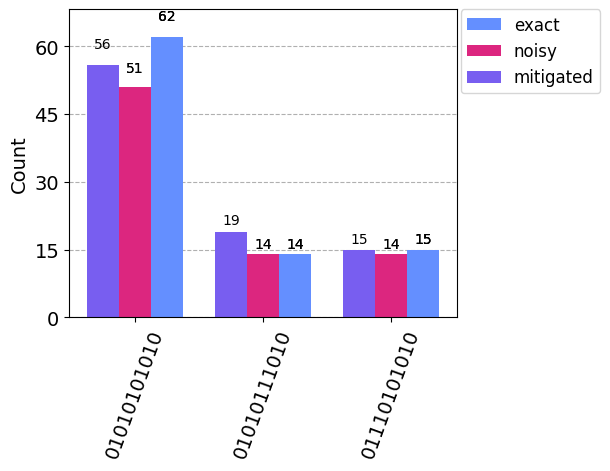

In [188]:
plot_histogram([d_exact, d_noisy, corrected_sv.sample_counts(num_shots)], 
               sort='value_desc', legend=['exact', 'noisy', 'mitigated'], 
               number_to_keep=3, figsize=(5, 4))